In [1]:
#Utsav Sonkar_6903269 (baseline logistic regreesion+ tuneddecision tree on the eda obtained from r)

# In Colab, files from my laptop aren't automatically available.
# This lets me upload the pre-processed CSVs that we created in R (train + test).
import os
if os.path.exists("/content"):  # Colab heuristic
    from google.colab import files
    uploaded = files.upload()

# Then read normally:(in case of running in jupyter or vs code, save the csv file locally)
#train_data = pd.read_csv("kidney_train.csv")
#test_data  = pd.read_csv("kidney_test.csv")#uncomment if required

# After running this cell, upload:
# 1) kidney_train.csv
# 2) kidney_test.csv


Saving kidney_test.csv to kidney_test (14).csv
Saving kidney_train.csv to kidney_train (14).csv


In [2]:
# Data handling (tables + arrays)
import pandas as pd
import numpy as np

# Preprocessing tools:
# - ColumnTransformer lets us apply different preprocessing to numeric vs categorical columns
# - OneHotEncoder turns text categories (like "abnormal") into numeric columns
# - SimpleImputer fills missing values so models don't crash
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models required in the coursework
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


# Evaluation metrics to compare models fairly
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, roc_curve, confusion_matrix

import matplotlib.pyplot as plt


In [3]:
# Load the datasets that were preprocessed in R studio.
# These should already be "mostly clean", but may still contain some categorical text fields.

train_data = pd.read_csv("kidney_train.csv")
test_data = pd.read_csv("kidney_test.csv")

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

# Quick peek so I know the data actually loaded correctly
train_data.head()


Train shape: (280, 25)
Test shape: (120, 25)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,classification
0,42,90,1.02,2,0,abnormal,abnormal,present,notpresent,93,...,34,9800,4.8,no,no,no,poor,yes,yes,ckd
1,68,70,1.02,0,0,normal,normal,notpresent,notpresent,98,...,40,8000,4.8,yes,yes,yes,poor,yes,no,ckd
2,80,70,1.01,2,0,normal,abnormal,notpresent,notpresent,121,...,40,8000,4.8,yes,yes,no,good,no,no,ckd
3,41,80,1.02,0,0,normal,normal,notpresent,notpresent,122,...,41,9100,5.2,no,no,no,good,no,no,notckd
4,55,70,1.02,0,0,normal,normal,notpresent,notpresent,219,...,37,9800,4.4,no,no,no,good,no,no,ckd


In [4]:
# The model should learn from features (X) to predict the target label (y).
# Here the target column is 'classification' (ckd vs notckd).

TARGET = "classification"

X_train = train_data.drop(columns=[TARGET])
y_train = train_data[TARGET].astype(str)

X_test = test_data.drop(columns=[TARGET])
y_test = test_data[TARGET].astype(str)

print("Train labels:", sorted(y_train.unique()))
print("Test labels :", sorted(y_test.unique()))


Train labels: ['ckd', 'notckd']
Test labels : ['ckd', 'notckd']


In [5]:
# Quick check: how many CKD vs notCKD cases do we have?
# This is important because strong class imbalance can bias model performance.

print("Class distribution (train):")
print(y_train.value_counts())

print("\nClass distribution (test):")
print(y_test.value_counts())


Class distribution (train):
classification
ckd       170
notckd    110
Name: count, dtype: int64

Class distribution (test):
classification
ckd       80
notckd    40
Name: count, dtype: int64


In [6]:
# Binary target for ROC-AUC calculations (1 = CKD, 0 = notCKD)
y_test_binary = (y_test == "ckd").astype(int)


In [7]:
# This is important because sklearn can't train a model if some columns are text,
# like 'abnormal', 'normal', 'yes', 'no', etc.
# We'll automatically detect which columns are numeric and which are categorical.

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Number of numeric columns:", len(numeric_cols))
print("Number of categorical columns:", len(categorical_cols))

# Showing a few categorical column names helps me check what's being encoded
print("Example categorical columns:", categorical_cols[:10])


Number of numeric columns: 14
Number of categorical columns: 10
Example categorical columns: ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


In [8]:
#preprocessing:
# - For numeric columns: fill missing values with the median (simple + robust)
# - For categorical columns: fill missing with most common value, then one-hot encode
# This is NOT "the feature engineering" — it's just making the data usable for the models.

numeric_preprocess = Pipeline(steps=[
    ("fill_missing", SimpleImputer(strategy="median"))
])

categorical_preprocess = Pipeline(steps=[
    ("fill_missing", SimpleImputer(strategy="most_frequent")),
    ("make_numeric", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("numbers", numeric_preprocess, numeric_cols),
        ("categories", categorical_preprocess, categorical_cols)
    ],
    remainder="drop"
)


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Baseline Logistic Regression:
# Not tuning hyperparameters here; this is a simple benchmark model.
# max_iter is increased to reduce the chance of convergence warnings.
logistic_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=20000, random_state=42))
])

# Train the model on the training dataset
logistic_pipeline.fit(X_train, y_train)

# Predict on unseen test dataset
logistic_predictions = logistic_pipeline.predict(X_test)

# ROC-AUC (select CKD probability by class name to avoid class-order assumptions)
model_classes = logistic_pipeline.named_steps["model"].classes_
ckd_index = list(model_classes).index("ckd")

logistic_probs = logistic_pipeline.predict_proba(X_test)[:, ckd_index]
logistic_roc_auc = roc_auc_score(y_test_binary, logistic_probs)

print("Logistic Regression ROC-AUC:", logistic_roc_auc)
print("Class order used by model:", model_classes)


Logistic Regression ROC-AUC: 0.9878125
Class order used by model: ['ckd' 'notckd']


In [10]:
# For medical-style classification, recall matters because false negatives are risky.
# Here, we treat "ckd" as the positive class (the disease case).
LABELS = ["notckd", "ckd"]

POS_LABEL = "ckd"

log_accuracy = accuracy_score(y_test, logistic_predictions)
log_precision = precision_score(y_test, logistic_predictions, pos_label=POS_LABEL, zero_division=0)
log_recall = recall_score(y_test, logistic_predictions, pos_label=POS_LABEL, zero_division=0)
log_f1 = f1_score(y_test, logistic_predictions, pos_label=POS_LABEL, zero_division=0)

print("Logistic Regression (Baseline)")
print("Accuracy :", log_accuracy)
print("Precision:", log_precision)
print("Recall   :", log_recall)
print("F1-score :", log_f1)
print("ROC-AUC  :", logistic_roc_auc)
LABELS = ["notckd", "ckd"]

log_confusion_matrix = confusion_matrix(
    y_test,
    logistic_predictions,
    labels=LABELS
)

print("Confusion Matrix (rows: actual, columns: predicted):")
print(log_confusion_matrix)



Logistic Regression (Baseline)
Accuracy : 0.9583333333333334
Precision: 0.9746835443037974
Recall   : 0.9625
F1-score : 0.9685534591194969
ROC-AUC  : 0.9878125
Confusion Matrix (rows: actual, columns: predicted):
[[38  2]
 [ 3 77]]


In [11]:
# Generate and display a detailed performance report for the Logistic Regression model,
# including precision, recall, F1-score, and support for each class.
# The `zero_division=0` parameter ensures the report is printed without errors
# if a class has no predicted samples.

from sklearn.metrics import classification_report
print("\nLogistic Regression - classification report:")
print(classification_report(y_test, logistic_predictions, zero_division=0))



Logistic Regression - classification report:
              precision    recall  f1-score   support

         ckd       0.97      0.96      0.97        80
      notckd       0.93      0.95      0.94        40

    accuracy                           0.96       120
   macro avg       0.95      0.96      0.95       120
weighted avg       0.96      0.96      0.96       120



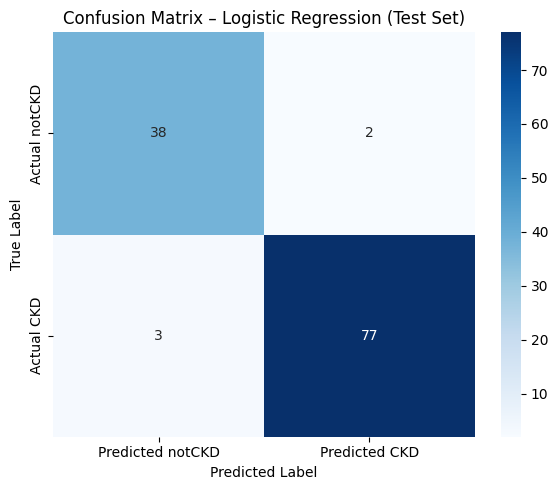

In [12]:
# Confusion matrix plot for Logistic Regression (test set)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

LABELS = ["notckd", "ckd"]

# Compute confusion matrix with fixed label order
cm_log = confusion_matrix(
    y_test,
    logistic_predictions,
    labels=LABELS
)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_log,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted notCKD", "Predicted CKD"],
    yticklabels=["Actual notCKD", "Actual CKD"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Logistic Regression (Test Set)")
plt.tight_layout()
plt.show()


In [13]:
# Baseline Decision Tree:
# I keep it shallow (max_depth=5) to reduce overfitting and keep it interpretable.
# random_state is just for reproducibility so results don't change every run.

tree_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(max_depth=5, random_state=42))
])

tree_pipeline.fit(X_train, y_train)
tree_predictions = tree_pipeline.predict(X_test)

# Decision Tree ROC-AUC (uses the same binary target)
tree_classes = tree_pipeline.named_steps["model"].classes_
ckd_index_tree = list(tree_classes).index("ckd")

tree_probs = tree_pipeline.predict_proba(X_test)[:, ckd_index_tree]
tree_roc_auc = roc_auc_score(y_test_binary, tree_probs)

print("Baseline Decision Tree ROC-AUC:", tree_roc_auc)
print("Class order used by tree:", tree_classes)



Baseline Decision Tree ROC-AUC: 0.96875
Class order used by tree: ['ckd' 'notckd']


In [14]:
# Evaluate the baseline Decision Tree model using common classification metrics.
# This calculates accuracy, precision, recall, and F1-score for the positive class,
# handling cases where a metric could be undefined (zero_division=0).
# It also prints the confusion matrix to show the breakdown of correct and incorrect predictions.

tree_accuracy = accuracy_score(y_test, tree_predictions)
tree_precision = precision_score(y_test, tree_predictions, pos_label=POS_LABEL, zero_division=0)
tree_recall = recall_score(y_test, tree_predictions, pos_label=POS_LABEL, zero_division=0)
tree_f1 = f1_score(y_test, tree_predictions, pos_label=POS_LABEL, zero_division=0)

print("Decision Tree (Baseline)")
print("Accuracy :", tree_accuracy)
print("Precision:", tree_precision)
print("Recall   :", tree_recall)
print("F1-score :", tree_f1)
print("ROC-AUC  :", tree_roc_auc)


LABELS = ["notckd", "ckd"]

tree_confusion_matrix = confusion_matrix(
    y_test,
    tree_predictions,
    labels=LABELS
)

print("Confusion Matrix (rows: actual, columns: predicted):")
print(tree_confusion_matrix)



Decision Tree (Baseline)
Accuracy : 0.975
Precision: 0.9753086419753086
Recall   : 0.9875
F1-score : 0.9813664596273292
ROC-AUC  : 0.96875
Confusion Matrix (rows: actual, columns: predicted):
[[38  2]
 [ 1 79]]


In [15]:
# Display a detailed classification report for the Decision Tree model(baseline),
# summarising precision, recall, F1-score, and support for each class.
# The `zero_division=0` option prevents errors when a class has no predicted samples.

print("\nBaseline Decision Tree - classification report:")
print(classification_report(y_test, tree_predictions, zero_division=0))



Baseline Decision Tree - classification report:
              precision    recall  f1-score   support

         ckd       0.98      0.99      0.98        80
      notckd       0.97      0.95      0.96        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



In [16]:
# Decision Tree pipeline (preprocessing + model)
tree_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])


In [17]:
# Hyperparameter grid for tuning the Decision Tree
# sensible, so it's clearly "tuning" but still manageable.

param_grid = {
    "model__max_depth": [3, 5, 7, 10, None],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__criterion": ["gini", "entropy"]
}


In [18]:
from sklearn.metrics import make_scorer, f1_score

# F1 for the CKD class specifically (positive class = "ckd")
f1_ckd = make_scorer(f1_score, pos_label="ckd")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=tree_pipe,
    param_grid=param_grid,
    scoring=f1_ckd,        # focus on CKD detection quality
    cv=cv,
    n_jobs=-1
)


In [19]:
# Run grid search cross-validation to identify the Decision Tree
# hyperparameters that achieve the best F1-score for CKD prediction.

grid.fit(X_train, y_train)

print("Best CV F1 (CKD):", grid.best_score_)
print("Best parameters:", grid.best_params_)


Best CV F1 (CKD): 0.9825221717499459
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}


In [20]:
# Best tuned model (pipeline)
best_tree_model = grid.best_estimator_

# Predictions on test set
tuned_tree_predictions = best_tree_model.predict(X_test)


In [21]:
# Standard metrics on test set
tuned_tree_accuracy = accuracy_score(y_test, tuned_tree_predictions)
tuned_tree_precision = precision_score(y_test, tuned_tree_predictions, pos_label="ckd", zero_division=0)
tuned_tree_recall = recall_score(y_test, tuned_tree_predictions, pos_label="ckd", zero_division=0)
tuned_tree_f1 = f1_score(y_test, tuned_tree_predictions, pos_label="ckd", zero_division=0)
tuned_tree_cm = confusion_matrix(y_test, tuned_tree_predictions)

# ROC-AUC needs probabilities + binary y
# y_test_binary is created earlier and reused for ROC-AUC


tree_classes = best_tree_model.named_steps["model"].classes_
ckd_index_tree = list(tree_classes).index("ckd")

tuned_tree_probs = best_tree_model.predict_proba(X_test)[:, ckd_index_tree]
tuned_tree_roc_auc = roc_auc_score(y_test_binary, tuned_tree_probs)

print("\nDecision Tree (Tuned)")
print("Accuracy :", tuned_tree_accuracy)
print("Precision:", tuned_tree_precision)
print("Recall   :", tuned_tree_recall)
print("F1-score :", tuned_tree_f1)
print("ROC-AUC  :", tuned_tree_roc_auc)
LABELS = ["notckd", "ckd"]

tuned_tree_confusion_matrix = confusion_matrix(
    y_test,
    tuned_tree_predictions,
    labels=LABELS
)

print("Confusion Matrix (rows: actual, columns: predicted):")
print(tuned_tree_confusion_matrix)



Decision Tree (Tuned)
Accuracy : 0.975
Precision: 0.963855421686747
Recall   : 1.0
F1-score : 0.9815950920245399
ROC-AUC  : 0.98625
Confusion Matrix (rows: actual, columns: predicted):
[[37  3]
 [ 0 80]]


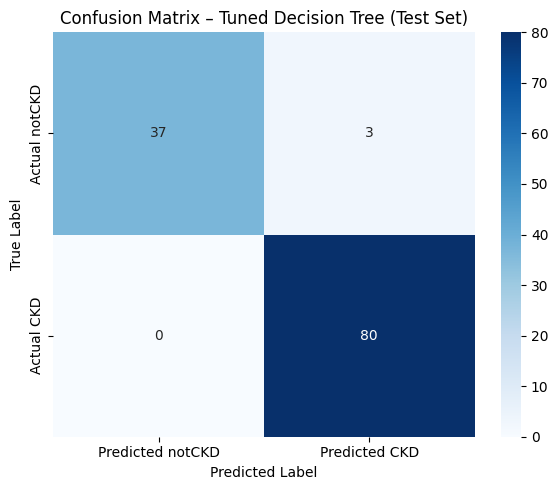

In [22]:
# Confusion matrix for the tuned Decision Tree model (test set)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

LABELS = ["notckd", "ckd"]

# Get predictions from the tuned Decision Tree
tuned_tree_predictions = best_tree_model.predict(X_test)

# Compute confusion matrix with fixed label order
cm = confusion_matrix(y_test, tuned_tree_predictions, labels=LABELS)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted notCKD", "Predicted CKD"],
    yticklabels=["Actual notCKD", "Actual CKD"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Tuned Decision Tree (Test Set)")
plt.tight_layout()
plt.show()


In [23]:
# A small summary table which will useful for the report for me and for comparing models clearly.

results_table = pd.DataFrame({
    "Model": [
        "Logistic Regression (Baseline)",
        "Decision Tree (Baseline)",
        "Decision Tree (Tuned)"
    ],
    "Accuracy":   [log_accuracy, tree_accuracy, tuned_tree_accuracy],
    "Precision":  [log_precision, tree_precision, tuned_tree_precision],
    "Recall":     [log_recall, tree_recall, tuned_tree_recall],
    "F1-score":   [log_f1, tree_f1, tuned_tree_f1],
    "ROC-AUC":    [logistic_roc_auc, tree_roc_auc, tuned_tree_roc_auc],
})


In [24]:
# Display a summary table comparing the performance of all models
display(results_table.round(4))


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Logistic Regression (Baseline),0.9583,0.9747,0.9625,0.9686,0.9878
1,Decision Tree (Baseline),0.9750,0.9753,0.9875,0.9814,0.9688
2,Decision Tree (Tuned),0.9750,0.9639,1.0000,0.9816,0.9862


In [25]:
# Import libraries for visualising the Decision Tree model.
# Matplotlib is used for plotting, and sklearn.tree provides tools
# to display and work with decision tree structures.

import matplotlib.pyplot as plt
from sklearn import tree


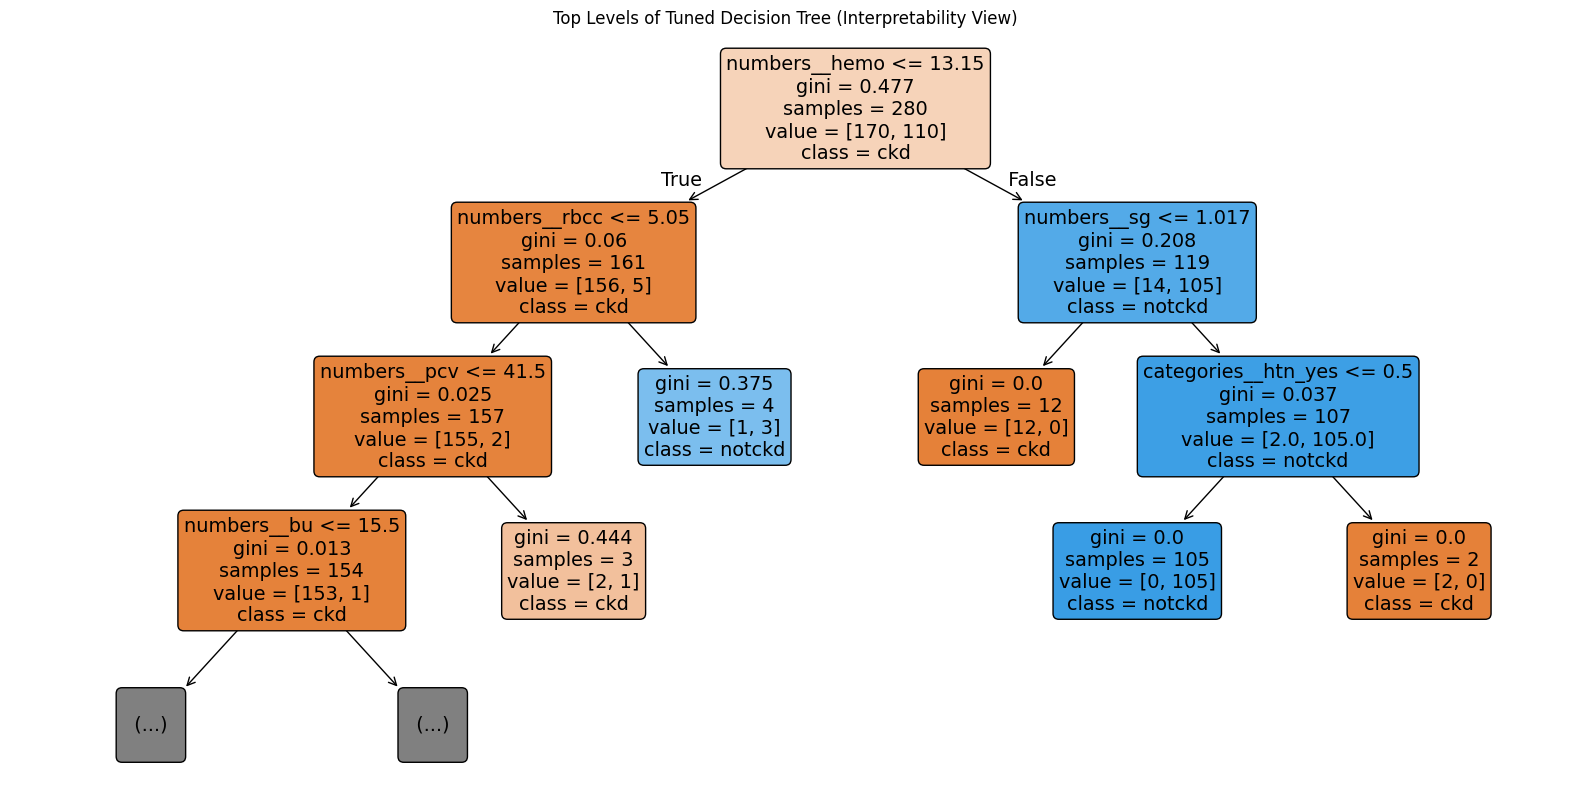

In [26]:
# Visualise only the top levels of the Decision Tree to improve interpretability.
# Limiting the depth highlights the most important early decision rules,
# making it easier to understand how the model initially splits the data.

from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

tree.plot_tree(
    best_tree_model.named_steps["model"],
    feature_names=best_tree_model.named_steps["prep"].get_feature_names_out(),
    class_names=best_tree_model.named_steps["model"].classes_,
    filled=True,
    rounded=True,
    max_depth=3
)

plt.title("Top Levels of Tuned Decision Tree (Interpretability View)")
plt.show()



In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, X_test, y_test, title):
    """
    Plots ROC curve for a fitted sklearn Pipeline model where the positive class is 'ckd'.
    """
    y_test_binary = (y_test == "ckd").astype(int)

    # Find the probability column corresponding to 'ckd'
    classes = model.named_steps["model"].classes_
    ckd_index = list(classes).index("ckd")

    probs = model.predict_proba(X_test)[:, ckd_index]

    fpr, tpr, _ = roc_curve(y_test_binary, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return roc_auc


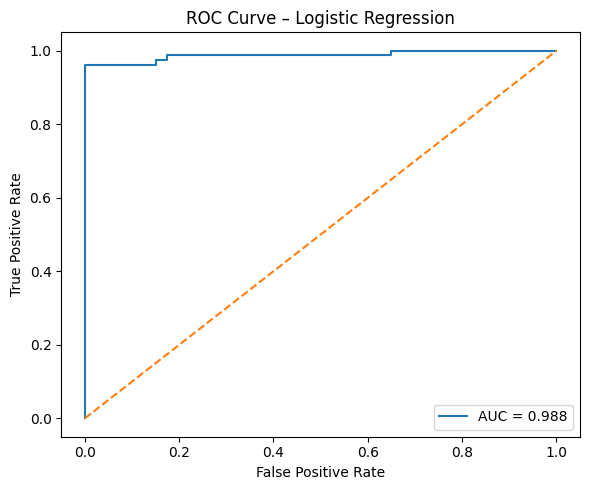

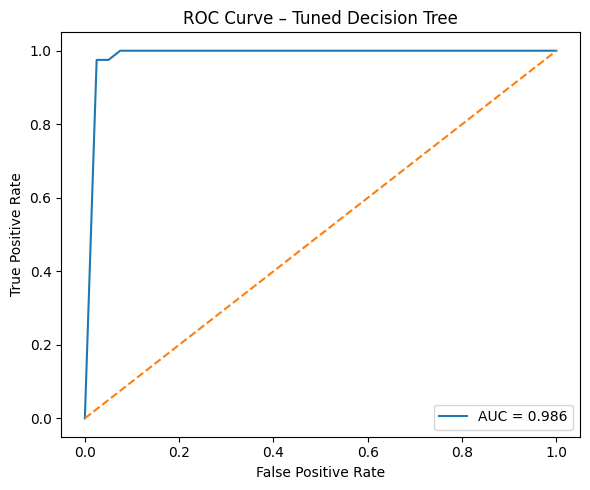

In [28]:
logistic_roc_auc = plot_roc_curve(
    logistic_pipeline, X_test, y_test,
    "ROC Curve – Logistic Regression"
)

tuned_tree_roc_auc = plot_roc_curve(
    best_tree_model, X_test, y_test,
    "ROC Curve – Tuned Decision Tree"
)# roc curves for both lr and tuned dt


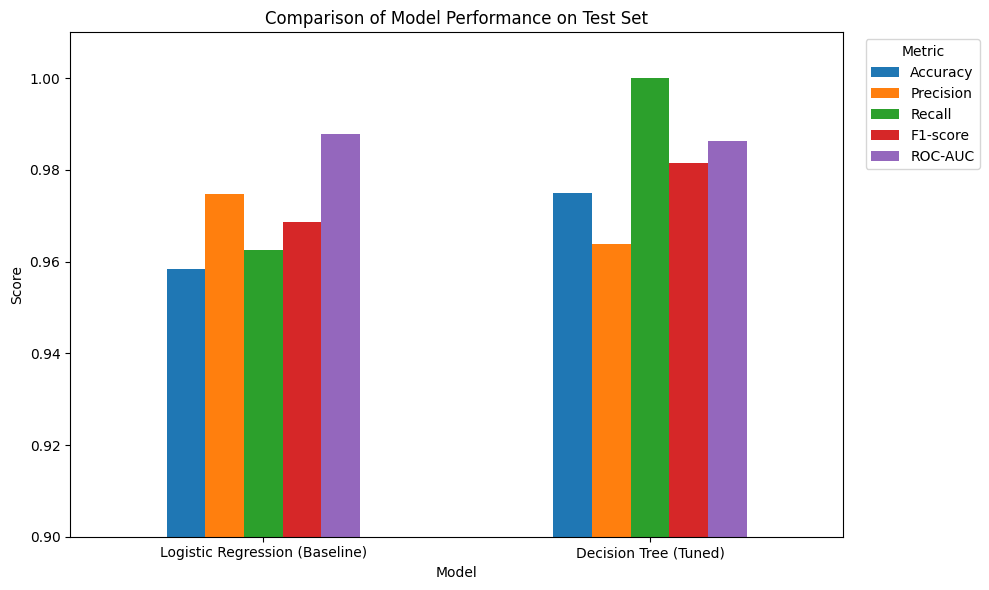

In [29]:
#bar charts to compare the performance of baseline lr and the tuned dt
import matplotlib.pyplot as plt

compare_models = [
    "Logistic Regression (Baseline)",
    "Decision Tree (Tuned)"
]

metrics = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]

plot_df = results_table[results_table["Model"].isin(compare_models)] \
    .set_index("Model")[metrics]

ax = plot_df.plot(kind="bar", figsize=(10, 6))
plt.ylim(0.9, 1.01)
plt.ylabel("Score")
plt.title("Comparison of Model Performance on Test Set")
plt.xticks(rotation=0)
plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


**The decision tree applies a sequence of if–else rules based on clinical measurements. Nodes closer to the root represent the most informative features for distinguishing CKD from non-CKD cases.**

Evaluation was conducted using accuracy, precision, recall, F1-score, ROC-AUC and confusion matrices on a held-out test set. These metrics were selected to balance overall performance with the importance of identifying CKD cases.

Final Summary and Notes

This notebook focuses on the modelling and evaluation stage of the coursework using the pre-processed Chronic Kidney Disease dataset provided in CSV format.

The datasets (kidney_train.csv and kidney_test.csv) were created earlier in R during the data understanding, cleaning, and exploratory analysis phase. As a result, this notebook does not repeat full data preparation steps and instead concentrates on applying and evaluating supervised machine learning models in Python, in line with the assessment brief.

Two classification models were implemented:

Logistic Regression, used as a simple and interpretable baseline linear model and shared benchmark across the group.

Decision Tree, implemented as a non-linear model and further improved through controlled hyperparameter tuning using cross-validation.

A preprocessing pipeline was applied in Python to handle any remaining missing values and categorical variables. Numerical features were imputed using the median, while categorical features were imputed using the most frequent value and one-hot encoded. These steps were kept minimal and were applied only to ensure model compatibility and prevent data leakage.

Both models were trained on the training dataset and evaluated on a held-out test set. Model performance was assessed using consistent evaluation metrics, including accuracy, precision, recall, F1-score, ROC–AUC, and confusion matrices, allowing for fair comparison. Particular emphasis was placed on recall for the CKD class, given the clinical importance of correctly identifying patients with kidney disease.

A results table was produced to summarise and compare model performance. In addition, the Decision Tree model was visualised to support interpretability, and confusion matrix heatmaps were used to clearly illustrate classification outcomes.

Overall, this notebook establishes a clear and reliable baseline performance benchmark, while also demonstrating how controlled model tuning can improve predictive performance. The results provide a strong foundation for further comparison with more advanced models developed by other group members.

In [30]:
# Export final model comparison results for use in the report
results_table.to_csv("utsav_lr_and_tuned_tree_results.csv", index=False)

try:
    from google.colab import files
    files.download("utsav_lr_and_tuned_tree_results.csv")
except Exception:
    print("Saved: utsav_lr_and_tuned_tree_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>